# Library

In [54]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import copy, os
from matplotlib import pyplot as plt
import seaborn as sns
import torch as torch

plt.style.use('ggplot')


from model.src.dataloader_robust import CheXpert
from model.src.custom_densenet121 import Custom_Densenet121
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Inspect the BN parameters are merged or not

In [ ]:
import torch, time

state_b1 = torch.load('./host_data/output/debug_dir/checkpoint_before_sync_e0_iter200.pth.tar')
print(state_b1.keys())
print(time.asctime(time.gmtime(float(state_b1['saving_time']))))

state_a1 = torch.load('./host_data/output/debug_dir/checkpoint_after_sync_e0_iter200.pth.tar')
print(state_a1.keys())
print(time.asctime(time.gmtime(float(state_a1['saving_time']))))

state_b2 = torch.load('./host_data/output/debug_dir2/checkpoint_before_sync_e0_iter200.pth.tar')
print(state_b2.keys())
print(time.asctime(time.gmtime(float(state_b2['saving_time']))))

state_a2 = torch.load('./host_data/output/debug_dir2/checkpoint_after_sync_e0_iter200.pth.tar')
print(state_a2.keys())
print(time.asctime(time.gmtime(float(state_a2['saving_time']))))

In [83]:
def compare_params(ref, target):
    a = [True]
    for n, params, in ref['model_state_dict'].items():
        s1 = params.cpu()
        s2 = taget['model_state_dict'][n].cpu()
        a.extend([np.allclose(s1, s2)])
        print(n, np.allclose(s1, s2))
    print(np.all(a))

print()
print('Compare both host checkpoints before SL merge.')
display(compare_params(state_b1, state_b2))

print('Compare single host checkpoints before and after SL merge.')
display(compare_params(state_b1, state_a1))

print('Compare both host checkpoints after SL merge.')
display(compare_params(state_a1, state_a2))


Compare both host checkpoints before SL merge.
features.conv0.weight False
features.norm0.weight False
features.norm0.bias False
features.norm0.running_mean False
features.norm0.running_var False
features.norm0.num_batches_tracked True
features.denseblock1.denselayer1.norm1.weight False
features.denseblock1.denselayer1.norm1.bias False
features.denseblock1.denselayer1.norm1.running_mean False
features.denseblock1.denselayer1.norm1.running_var False
features.denseblock1.denselayer1.norm1.num_batches_tracked True
features.denseblock1.denselayer1.conv1.weight False
features.denseblock1.denselayer1.norm2.weight False
features.denseblock1.denselayer1.norm2.bias False
features.denseblock1.denselayer1.norm2.running_mean False
features.denseblock1.denselayer1.norm2.running_var False
features.denseblock1.denselayer1.norm2.num_batches_tracked True
features.denseblock1.denselayer1.conv2.weight False
features.denseblock1.denselayer2.norm1.weight False
features.denseblock1.denselayer2.norm1.bias F

None

Compare single host checkpoints before and after SL merge.
features.conv0.weight False
features.norm0.weight False
features.norm0.bias False
features.norm0.running_mean False
features.norm0.running_var False
features.norm0.num_batches_tracked True
features.denseblock1.denselayer1.norm1.weight False
features.denseblock1.denselayer1.norm1.bias False
features.denseblock1.denselayer1.norm1.running_mean False
features.denseblock1.denselayer1.norm1.running_var False
features.denseblock1.denselayer1.norm1.num_batches_tracked True
features.denseblock1.denselayer1.conv1.weight False
features.denseblock1.denselayer1.norm2.weight False
features.denseblock1.denselayer1.norm2.bias False
features.denseblock1.denselayer1.norm2.running_mean False
features.denseblock1.denselayer1.norm2.running_var False
features.denseblock1.denselayer1.norm2.num_batches_tracked True
features.denseblock1.denselayer1.conv2.weight False
features.denseblock1.denselayer2.norm1.weight False
features.denseblock1.denselayer2.n

None

Compare both host checkpoints after SL merge.
features.conv0.weight True
features.norm0.weight True
features.norm0.bias True
features.norm0.running_mean True
features.norm0.running_var True
features.norm0.num_batches_tracked True
features.denseblock1.denselayer1.norm1.weight True
features.denseblock1.denselayer1.norm1.bias True
features.denseblock1.denselayer1.norm1.running_mean True
features.denseblock1.denselayer1.norm1.running_var True
features.denseblock1.denselayer1.norm1.num_batches_tracked True
features.denseblock1.denselayer1.conv1.weight True
features.denseblock1.denselayer1.norm2.weight True
features.denseblock1.denselayer1.norm2.bias True
features.denseblock1.denselayer1.norm2.running_mean True
features.denseblock1.denselayer1.norm2.running_var True
features.denseblock1.denselayer1.norm2.num_batches_tracked True
features.denseblock1.denselayer1.conv2.weight True
features.denseblock1.denselayer2.norm1.weight True
features.denseblock1.denselayer2.norm1.bias True
features.dense

None

# Explore the dataset without Imputing Taget Label

In [2]:
train_set = pd.read_csv('./host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small/train.csv')
#train_set.rename(columns={'Pleural Effusion':'Effusion'}, inplace=True)
display('original train_set',train_set.head())
print()

val_set = pd.read_csv('./host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small/valid.csv')
#val_set.rename(columns={'Pleural Effusion':'Effusion'}, inplace=True)
display('original val_set', val_set.head())
print()

'original train_set'

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


'original val_set'

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


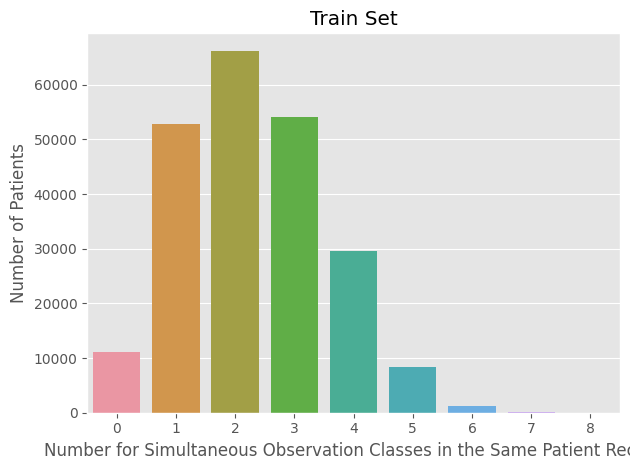

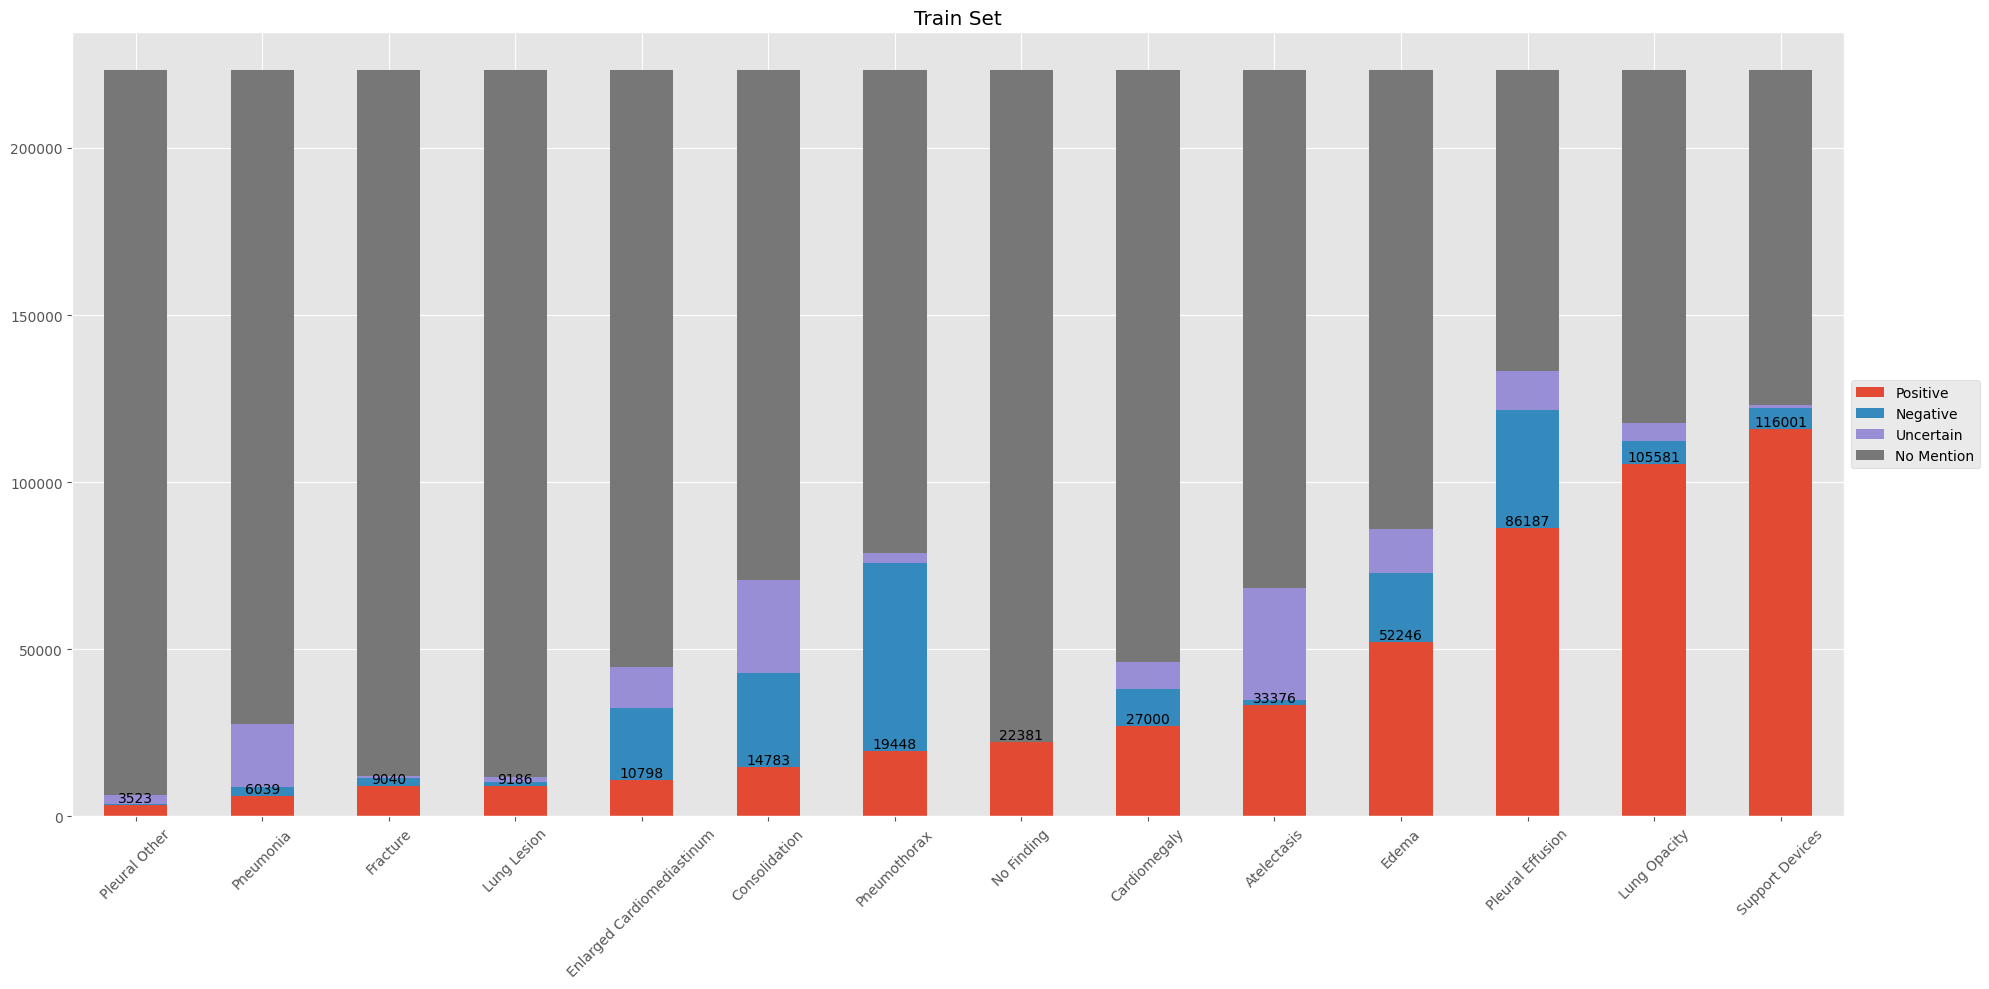

,Positive,Negative,Uncertain,No Mention
No Finding,22381,0,0,201033
Enlarged Cardiomediastinum,10798,21638,12403,178575
Cardiomegaly,27000,11116,8087,177211
Lung Opacity,105581,6599,5598,105636
Lung Lesion,9186,1270,1488,211470
Edema,52246,20726,12984,137458
Consolidation,14783,28097,27742,152792
Pneumonia,6039,2799,18770,195806
Atelectasis,33376,1328,33739,154971
Pneumothorax,19448,56341,3145,144480


In [3]:
# Training Set Distribution

all_classes = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
#all_classes = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',  'Pleural Effusion']

train_set_disease = train_set.loc[:,all_classes].fillna(-2).astype(np.int8)

temp1 = (train_set_disease==1).sum(axis=1)
sns.countplot(data=temp1.to_frame(), x=0)
plt.title("Train Set")
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.show()


m1=(train_set_disease==1).sum(axis=0)
m0=(train_set_disease==0).sum(axis=0)
mu=(train_set_disease==-1).sum(axis=0)
mna=(train_set_disease==-2).sum(axis=0)
train_set_disease_summary = pd.DataFrame([m1, m0, mu, mna]).transpose()
train_set_disease_summary.columns=['Positive','Negative', 'Uncertain', 'No Mention']
axes = train_set_disease_summary.sort_values(["Positive","Negative"]).plot(kind='bar', figsize=(20,10), stacked=True, rot=45)
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for c in axes.containers:
    axes.bar_label(c)
    break
#train_set_disease_summary.iloc[:,:3].plot(kind='bar', figsize=(20,10))
plt.tick_params('x', labelrotation=45)
plt.title("Train Set")
plt.tight_layout()
plt.show()

display(train_set_disease_summary)

In validation set, 62.82051282051282% are multilabel patient.
In validation set, 3.8461538461538463% are multilabel patient.
In validation set, 33.33333333333333% are multilabel patient.


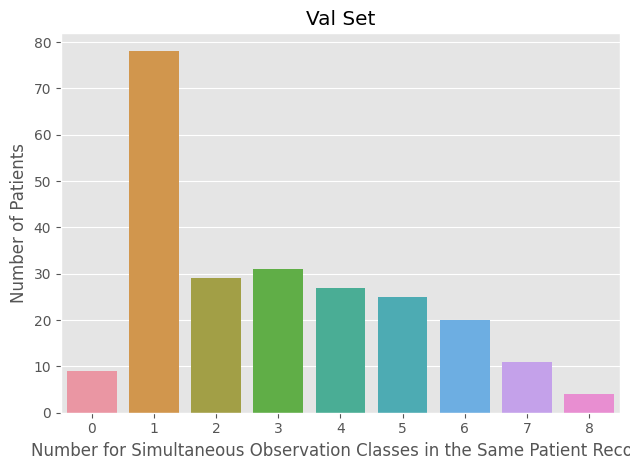

,Positive,Negative
Fracture,0,234
Lung Lesion,1,233
Pleural Other,1,233
Pneumonia,8,226
Pneumothorax,8,226
Consolidation,33,201
No Finding,38,196
Edema,45,189
Pleural Effusion,67,167
Cardiomegaly,68,166


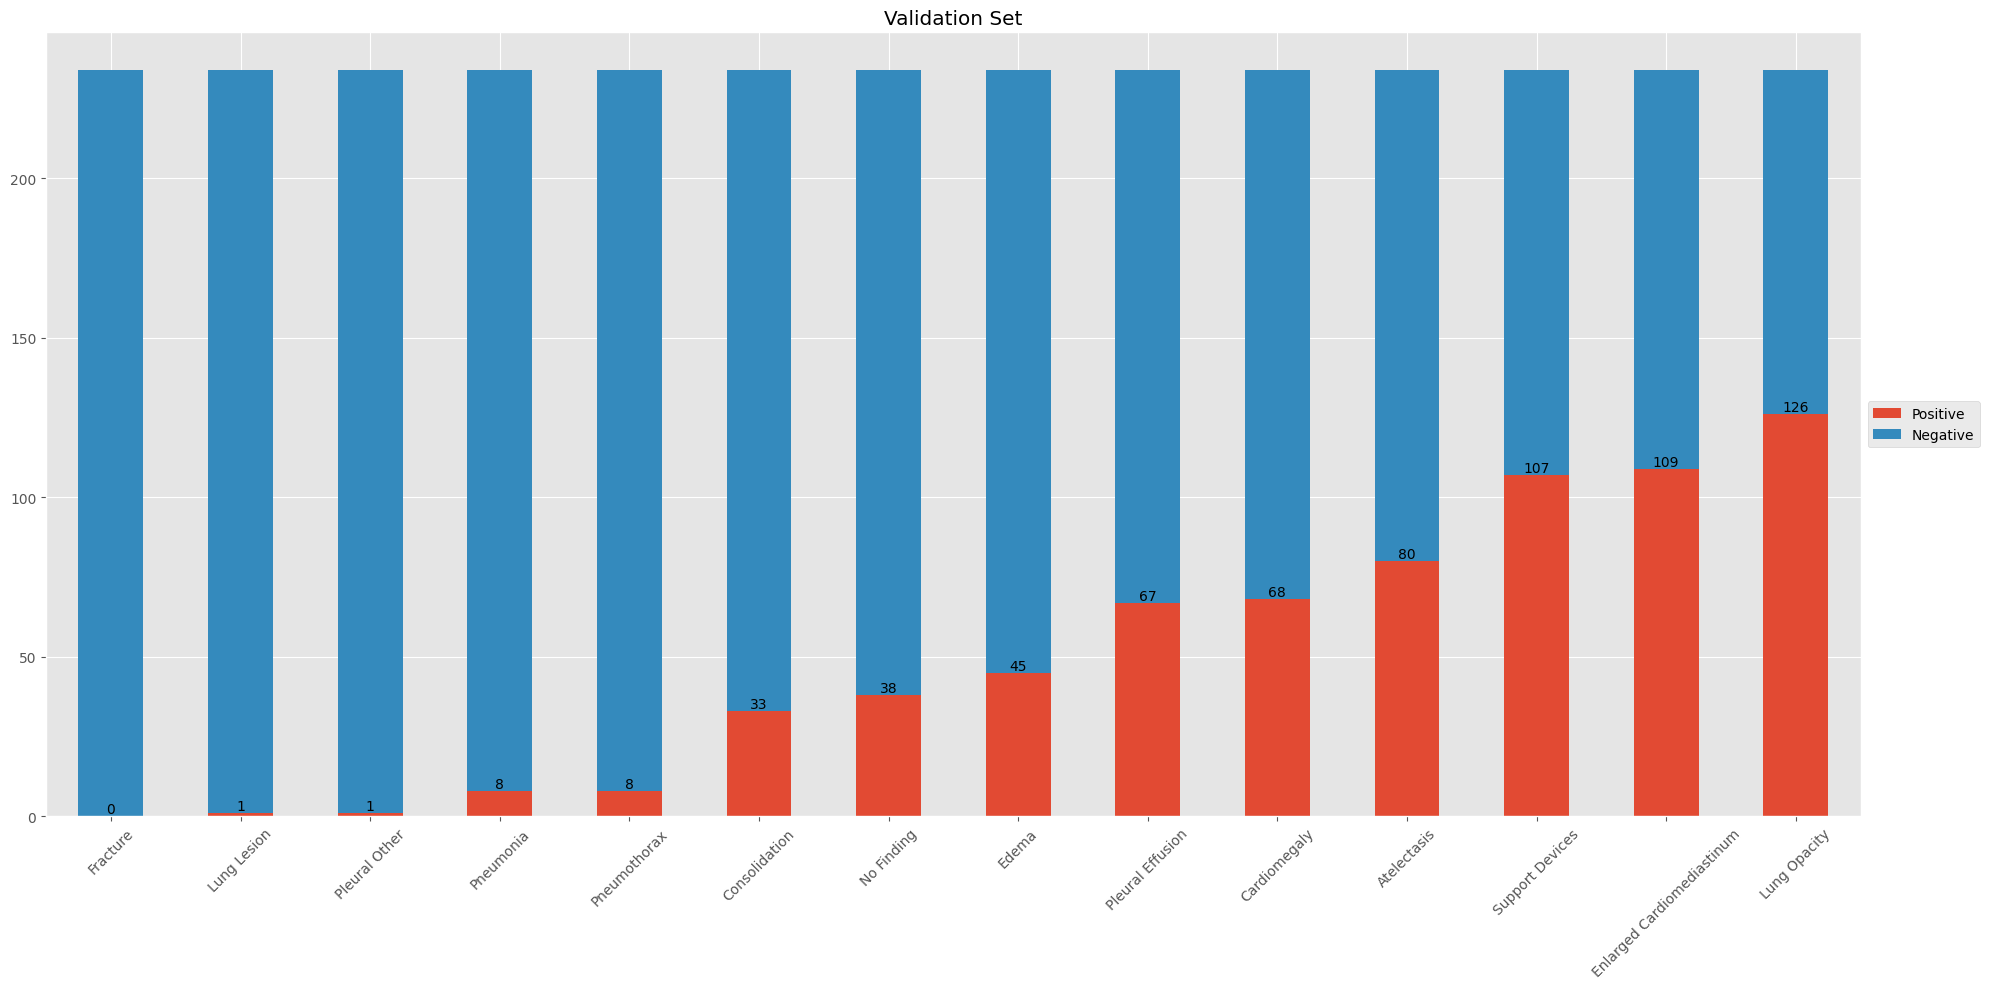

In [4]:
# Val Set Distribution
val_set_disease = val_set.loc[:,all_classes].fillna(-2).astype(np.int8)

temp_acc = 0
temp = (val_set.loc[:,all_classes].sum(axis=1)>1.5).sum()/val_set.shape[0]
print("In validation set, {}% are multilabel patient.".format(temp*100))
temp_acc=temp

temp = (val_set.loc[:,all_classes].sum(axis=1)<0.1).sum()/val_set.shape[0]
print("In validation set, {}% are multilabel patient.".format(temp*100))
temp_acc = temp_acc + temp

temp = (val_set.loc[:,all_classes].sum(axis=1)==1.0).sum()/val_set.shape[0]
print("In validation set, {}% are multilabel patient.".format(temp*100))
temp_acc = temp_acc + temp

assert int(temp_acc*100) == int(100)

temp = val_set_disease.loc[:,all_classes].sum(axis=1)
sns.countplot(temp.to_frame(), x=0)
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.title("Val Set")
plt.tight_layout()
plt.show()

# display(val_set_disease.sum().sort_values())
# ax = val_set_disease.sum().sort_values().plot(kind='bar',rot=45, figsize=(20,10), title="Multilabel Observation Class Distribution in Validation Set")
# ax.set_ylabel('Count')
# plt.show()

temp1=(val_set.loc[:,all_classes]==1).sum().sort_values()
temp2=(val_set.loc[:,all_classes]==0).sum()
temp=pd.DataFrame({"1":temp1, "0":temp2}).sort_values("1")
temp.columns = ['Positive','Negative']
display(temp)
axes = temp.plot(kind='bar', rot=45, figsize=(20,10), stacked=True, title="Validation Set")
axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for c in axes.containers:
    axes.bar_label(c)
    break
plt.tight_layout()
plt.show()


# plt.figure(figsize=(20,10))
# aa = temp.reset_index()
# aa = aa.melt(id_vars='index')
# axs = sns.barplot(data=aa, x='index', y='value', hue='variable')
# axs.tick_params(axis='x', labelrotation=45)

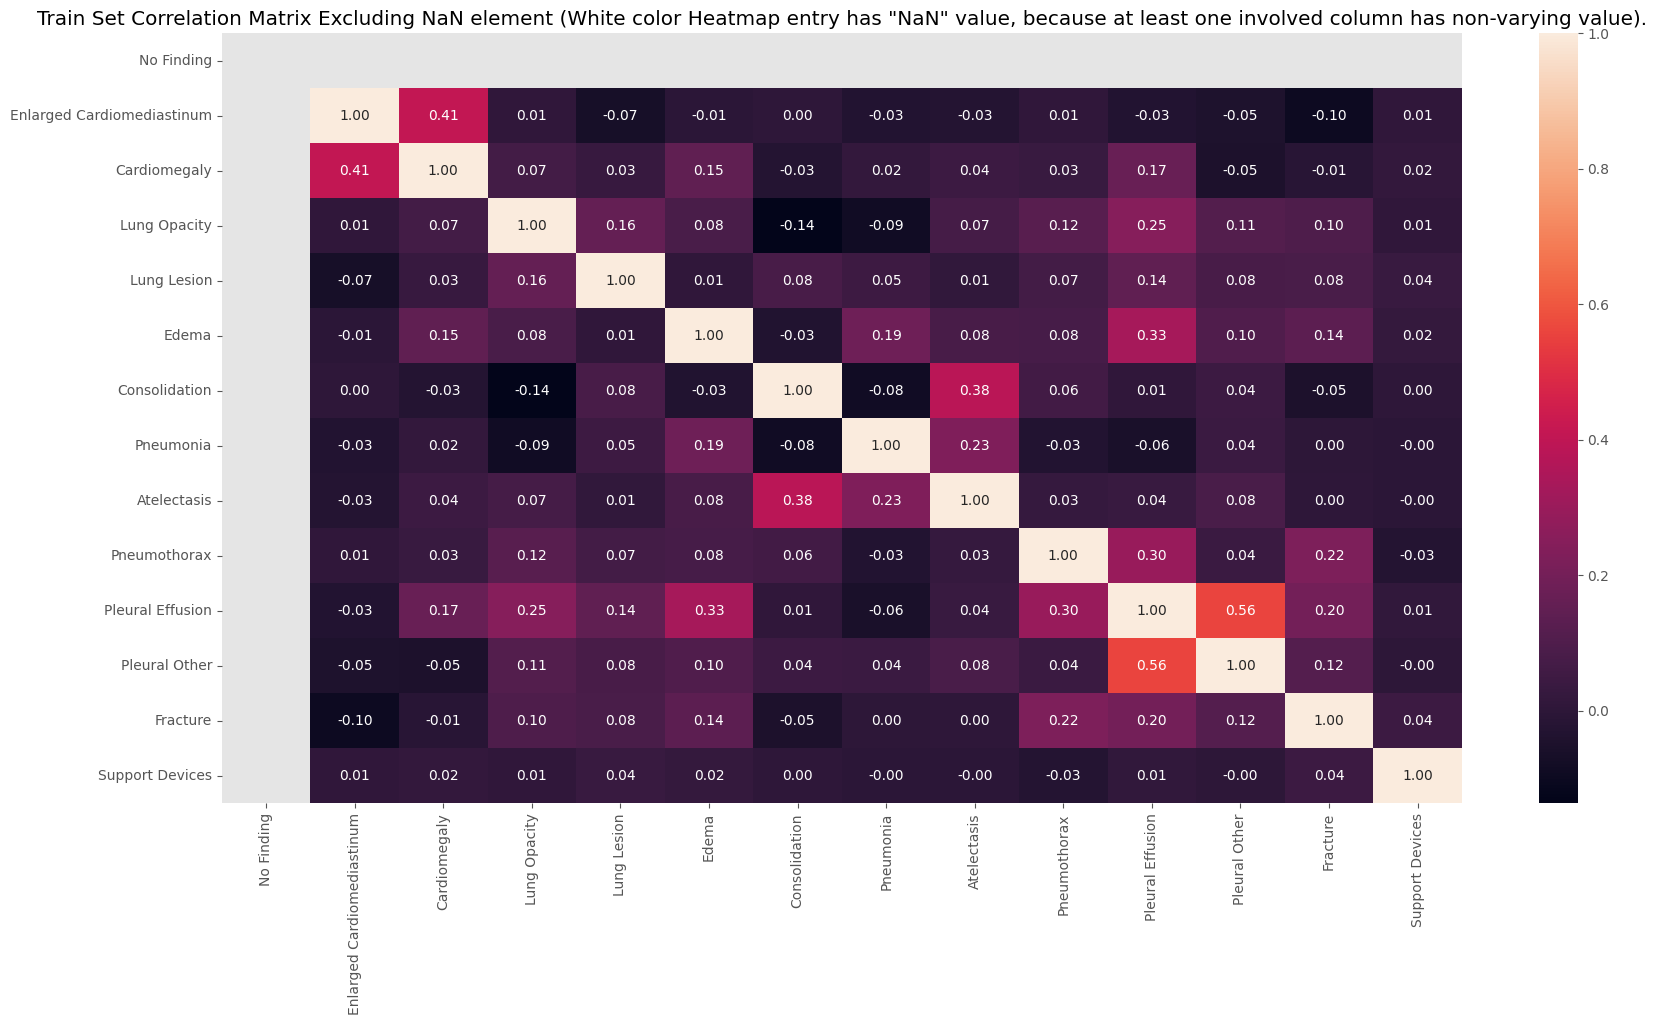

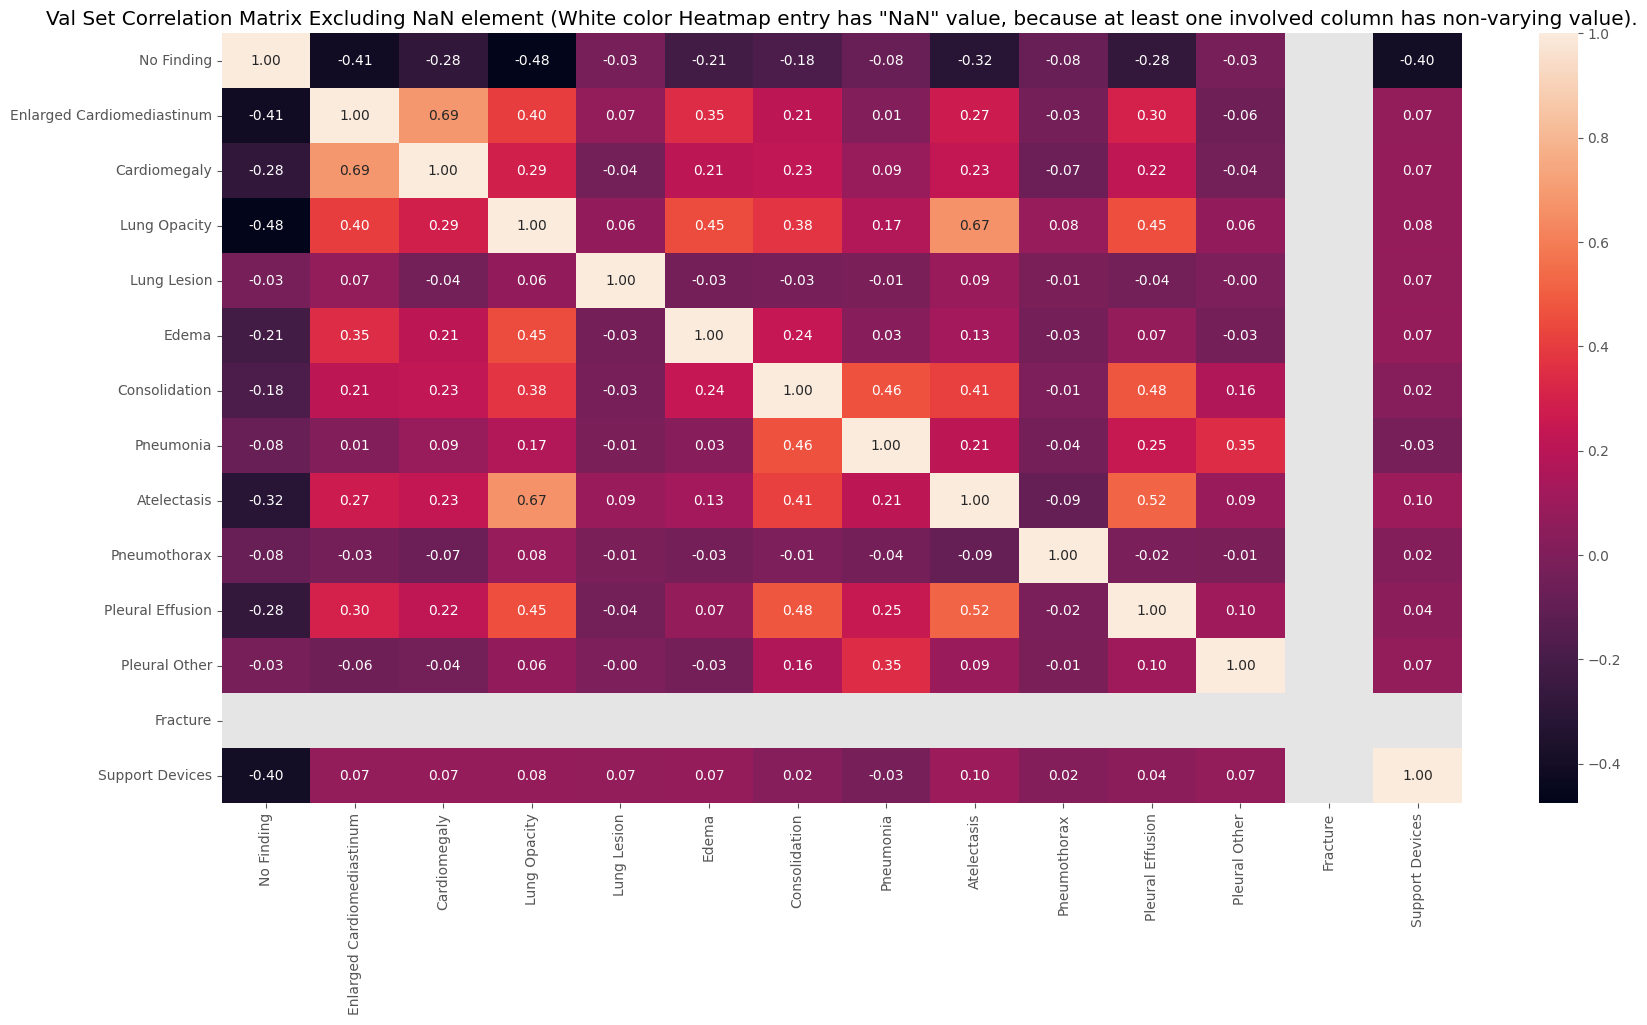

In [5]:
# Inspect co-occurance
train_set_disease_temp = train_set.loc[:,all_classes]
plt.figure(figsize=(20,10))
sns.heatmap(train_set_disease_temp.corr(numeric_only=False), annot=True, fmt=".2f")
plt.title('Train Set Correlation Matrix Excluding NaN element (White color Heatmap entry has "NaN" value, because at least one involved column has non-varying value).')
plt.show()

val_set_disease_temp = val_set.loc[:,all_classes]
plt.figure(figsize=(20,10))
sns.heatmap(val_set_disease_temp.corr(numeric_only=False), annot=True, fmt=".2f")
plt.title('Val Set Correlation Matrix Excluding NaN element (White color Heatmap entry has "NaN" value, because at least one involved column has non-varying value).')
plt.show()


# Explore the dataset with Imputing the Target Labels

In [7]:
train_cols = all_classes
#train_cols = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',  'Pleural Effusion']

root = "/tmp/test/workspace_lung_disease/sl_version/host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small"

traindSet  = CheXpert(csv_path=os.path.join(root,'train.csv'), image_root_path=root, use_upsampling=False, use_frontal=True, image_size=320, mode='train', class_index=-1, shuffle=False, seed=123, train_cols=train_cols)

/tmp/test/workspace_lung_disease/sl_version/model/src/dataloader_robust.py:41: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df['Path'] = self.df['Path'].str.replace('CheXpert-v1.0-small/', '')
/tmp/test/workspace_lung_disease/sl_version/model/src/dataloader_robust.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df['Path'] = self.df['Path'].str.replace('CheXpert-v1.0/', '')


Multi-label mode: True, Number of classes: [14]
------------------------------
Found 191027 images in total, 16974 positive images, 174053 negative images
No Finding(C0): imbalance ratio is 0.0889

Found 191027 images in total, 19473 positive images, 171554 negative images
Enlarged Cardiomediastinum(C1): imbalance ratio is 0.1019

Found 191027 images in total, 23385 positive images, 167642 negative images
Cardiomegaly(C2): imbalance ratio is 0.1224

Found 191027 images in total, 98642 positive images, 92385 negative images
Lung Opacity(C3): imbalance ratio is 0.5164

Found 191027 images in total, 8148 positive images, 182879 negative images
Lung Lesion(C4): imbalance ratio is 0.0427

Found 191027 images in total, 61493 positive images, 129534 negative images
Edema(C5): imbalance ratio is 0.3219

Found 191027 images in total, 12983 positive images, 178044 negative images
Consolidation(C6): imbalance ratio is 0.0680

Found 191027 images in total, 20656 positive images, 170371 negative im

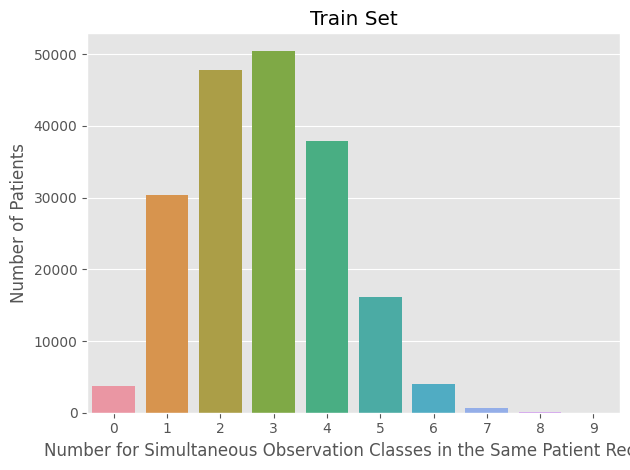

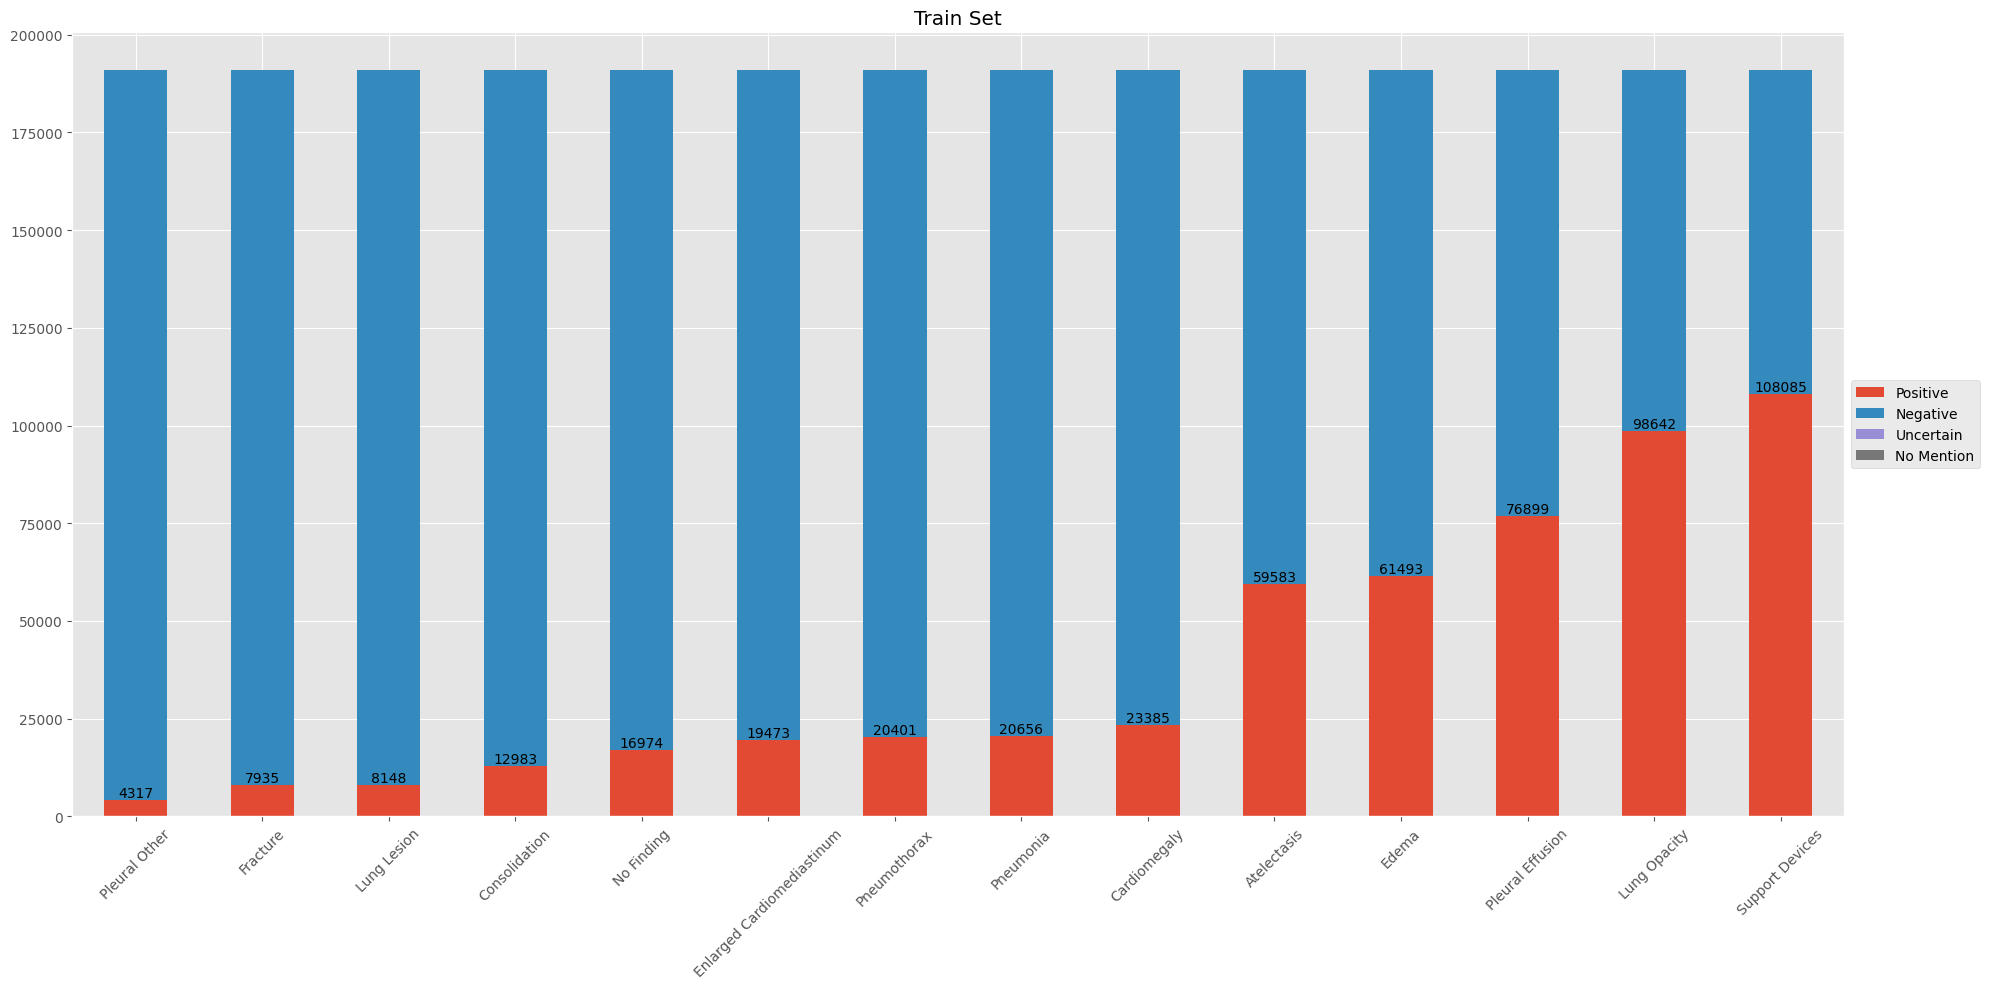

In [8]:
# Training Set Distribution

train_set_disease = traindSet.df.loc[:,train_cols].astype(np.int8)

temp1 = (train_set_disease==1).sum(axis=1)
sns.countplot(data=temp1.to_frame(), x=0)
plt.title("Train Set")
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.show()

m1=(train_set_disease==1).sum(axis=0)
m0=(train_set_disease==0).sum(axis=0)
mu=(train_set_disease==-1).sum(axis=0)
mna=(train_set_disease==-2).sum(axis=0)
train_set_disease_summary = pd.DataFrame([m1, m0, mu, mna]).transpose()
train_set_disease_summary.columns=['Positive','Negative', 'Uncertain', 'No Mention']
axes = train_set_disease_summary.sort_values(["Positive","Negative"]).plot(kind='bar', figsize=(20,10), stacked=True, rot=45)
axes.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
axes.bar_label(axes.containers[0])
#train_set_disease_summary.iloc[:,:3].plot(kind='bar', figsize=(20,10))
plt.tick_params('x', labelrotation=45)
plt.title("Train Set")
plt.tight_layout()
plt.show()

# display(train_set_disease_summary)
# d=True, rot=45)
# axes.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])
# #train_set_disease_summary.iloc[:,:3].plot(kind='bar', figsize=(20,10))
# plt.tick_params('x', labelrotation=45)
# plt.title("Train Set")
# plt.tight_layout()
# plt.show()

#display(train_set_disease_summary)


# Data Splitting for Swarm Learning Nodes

In [ ]:
import copy
display(train_cols )
host1_ratio = [0.8, 0.8, 0.8, 0.15, 0.6]

def f1(df, col, ratio, offset=0):
    temp1 = df.loc[:,col]
    temp2 = temp1.loc[temp1==1]
    if offset >= temp2.shape[0]*ratio:
        print('skip f1 because offset={}'.format(offset))
        return []
    else:
        temp3 = np.random.choice(temp2.shape[0], int(temp2.shape[0]*ratio) - offset, replace=False)
        index2 = temp2.iloc[temp3].index
        print(index2.shape[0]/temp2.shape[0])
        return index2

display(train_set_disease.sum())
dfx = copy.deepcopy(train_set_disease)
dfy = None
indices = []
for col, ratio in zip(train_cols, host1_ratio):
    print('#################################################')
    print('#################################################')

    if dfx.shape[0] == train_set_disease.shape[0]:
        already_have=0
    else:
        already_have = int(dfy.loc[:,col].sum())
        print('already_have:', already_have)

    if dfy is not None:
        print(dfy.sum(axis=0))
    print(already_have)
    index = list(np.array(f1(dfx, col, ratio, offset=already_have)))
    indices.extend(index)

    dfy = copy.deepcopy(train_set_disease.loc[train_set_disease.index.isin(indices),:])
    mask = ~dfx.index.isin(index)
    dfx = dfx.iloc[mask,:]
    print(col, ratio, len(index))
    print('#################################################')


print('#################################################')
print('#################################################')
display(dfy.sum())
display(train_set_disease.loc[indices].sum())
display(max(indices))

print('#################################################')
print('#################################################')
mask = train_set_disease.loc[:,train_cols].sum(axis=1)<0.5
display(mask.sum())
temp2 = train_set_disease.loc[mask,:]
temp3 = np.random.choice(temp2.shape[0], int(temp2.shape[0]*0.5), replace=False)
index2 = temp2.iloc[temp3].index
indices.extend(list(index2))

print('#################################################')
print('#################################################')
display(train_set_disease.loc[indices].sum())


In [ ]:
p1 = traindSet.df.loc[traindSet.df.index.isin(indices),:]
p2 = traindSet.df.loc[~traindSet.df.index.isin(indices),:]
p1.reset_index(inplace=True, drop=False)
p2.reset_index(inplace=True, drop=False)
assert (p1.loc[:,'index'].unique().shape[0] == p1.shape[0])
assert (p2.loc[:,'index'].unique().shape[0] == p2.shape[0])
p1.to_csv('./host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small/train_sl1.csv')
p2.to_csv('./host_data/train_data/LungDiseaseDataset/CheXpert-v1.0-small/train_sl2.csv')
p11 = p1.loc[:, train_cols]
p22 = p2.loc[:, train_cols]
display(p11.sum())
display(p22.sum())
display(max(indices))
display(p11.shape[0]+p22.shape[0])


temp1 = (p11==1).sum(axis=1)
sns.countplot(data=temp1.to_frame(), x=0)
plt.title("Train Set for Host 1")
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.show()


temp1 = (p22==1).sum(axis=1)
sns.countplot(data=temp1.to_frame(), x=0)
plt.title("Train Set for Host 2")
plt.xlabel("Number for Simultaneous Observation Classes in the Same Patient Record")
plt.ylabel('Number of Patients')
plt.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.show()

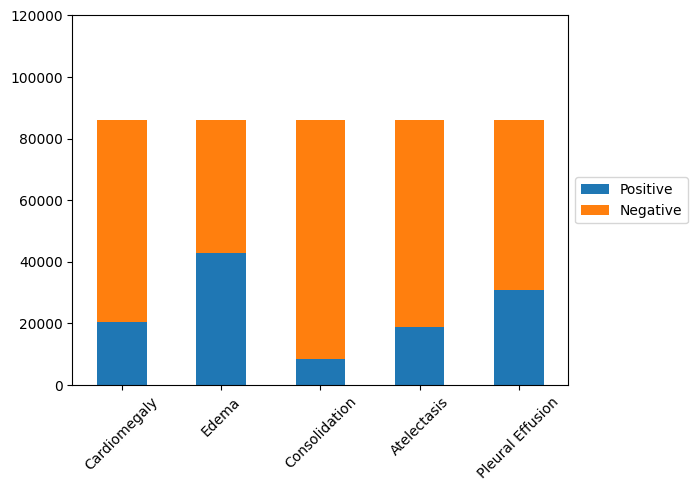

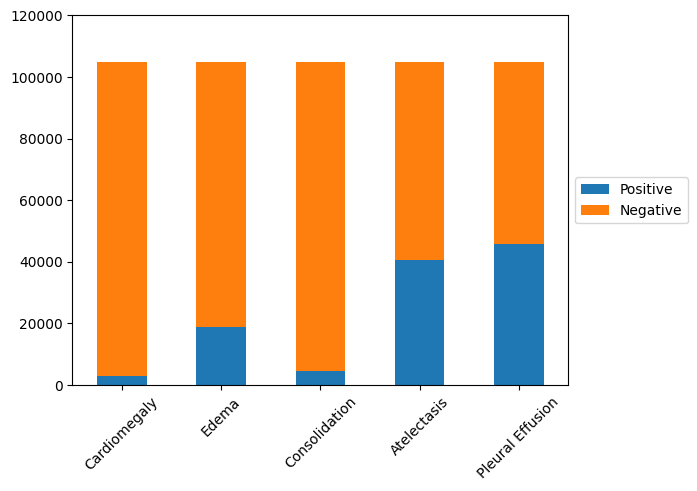

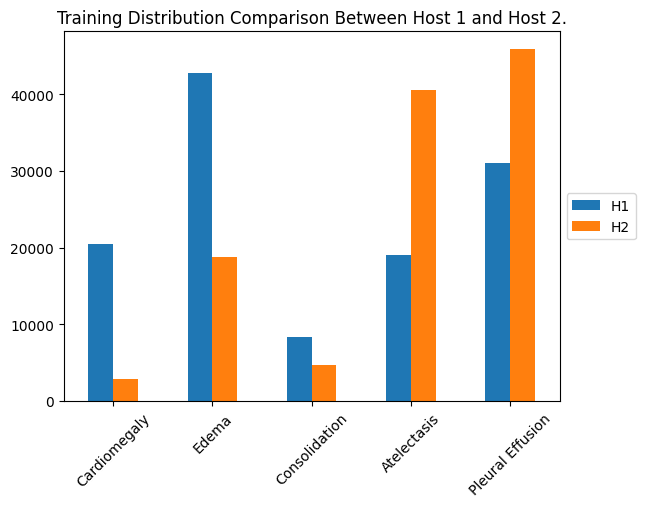

In [425]:
positive = p11.transpose().sum(axis=1)
negative = p11.transpose().shape[1] - positive
temp = pd.DataFrame(index=p11.transpose().index, data={'Positive': positive, 'Negative': negative})
axes = temp.plot(kind='bar', stacked=True, rot=45)
axes.set_ylim(ymin=0, ymax=120000)
axes.legend(loc='center left', bbox_to_anchor=[1.0,0.5])
temp1 = copy.deepcopy(temp)

positive = p22.transpose().sum(axis=1)
negative = p22.transpose().shape[1] - positive
temp = pd.DataFrame(index=p22.transpose().index, data={'Positive': positive, 'Negative': negative})
axes = temp.plot(kind='bar', stacked=True, rot=45)
axes.set_ylim(ymin=0, ymax=120000)
axes.legend(loc='center left', bbox_to_anchor=[1.0,0.5])

temp1.columns = ['H1', 'H2']
temp1.loc[:,'H2'] = temp['Positive']
axes = temp1.plot(kind='bar', stacked=False, rot=45)
plt.title('Training Distribution Comparison Between Host 1 and Host 2.')
axes.legend(loc='center left', bbox_to_anchor=[1.0,0.5])


# Visualize Training Result Over Iterations

In [60]:
aa = torch.load("./host_data/output/checkpoint_host1/single_node1/checkpoint_e2_iter2400.pth.tar")
bb = aa['val_metrics']
len(bb['val_auc_mean'])

21

In [33]:
train_cols = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',  'Pleural Effusion']
centralized_paths = ["./host_data/output/checkpoint_host1/centralized1/model_checkpoint/checkpoint_e2_iter5600.pth.tar", "./host_data/output/checkpoint_host1/centralized2/checkpoint_e2_iter5600.pth.tar", 
                     "./host_data/output/checkpoint_host2/centralized1/model_checkpoint/checkpoint_e2_iter5600.pth.tar", "./host_data/output/checkpoint_host2/centralized2/checkpoint_e2_iter5600.pth.tar"]
single_node_paths = ["./host_data/output/checkpoint_host1/single_node2/checkpoint_e4_iter2400.pth.tar", "./host_data/output/checkpoint_host1/single_node3/checkpoint_e4_iter2400.pth.tar","./host_data/output/checkpoint_host1/single_node4/checkpoint_e4_iter2400.pth.tar"]
single_node_paths_2 = ["./host_data/output/checkpoint_host2/single_node2/checkpoint_e4_iter3200.pth.tar", "./host_data/output/checkpoint_host2/single_node3/checkpoint_e4_iter3200.pth.tar", "./host_data/output/checkpoint_host2/single_node4/checkpoint_e4_iter3200.pth.tar"]
sl1_paths = ["./host_data/output/checkpoint_host1/sl1/checkpoint_e4_iter2400.pth.tar", "./host_data/output/checkpoint_host1/sl2/checkpoint_e4_iter2400.pth.tar", "./host_data/output/checkpoint_host1/sl3/checkpoint_e4_iter2400.pth.tar"]
sl2_paths = ["./host_data/output/checkpoint_host2/sl1/checkpoint_e4_iter3200.pth.tar","./host_data/output/checkpoint_host2/sl2/checkpoint_e4_iter3200.pth.tar", "./host_data/output/checkpoint_host2/sl3/checkpoint_e4_iter3200.pth.tar"]

def load_metric_list(result_paths, train_cols):
    acc_list = []
    for p in result_paths:
        state1 = torch.load(p)
        val_metrics = pd.DataFrame(state1['val_metrics'])
        val_metrics = val_metrics.applymap(lambda x: x[0] if len(x)==1 else x)
        for i in range(len(train_cols)):
            val_metrics[train_cols[i]] = val_metrics.loc[:, 'val_auc_class'].apply(lambda x: x[i])
        acc_list.extend([val_metrics])
    return acc_list

centralized_results  = load_metric_list(centralized_paths, train_cols)
display(centralized_results[0].columns, centralized_results[0].shape)

single_node_results  = load_metric_list(single_node_paths, train_cols)
display(single_node_results[0].columns, single_node_results[0].shape)

single_node_results_2  = load_metric_list(single_node_paths_2, train_cols)
display(single_node_results_2[0].columns, single_node_results_2[0].shape)

sl1_results  = load_metric_list(sl1_paths, train_cols)
display(sl1_results[0].columns, sl1_results[0].shape)

sl2_results  = load_metric_list(sl2_paths, train_cols)
display(sl2_results[0].columns, sl2_results[0].shape)

# acc = []
# for c in centralized_results:
#     acc.extend([c.iloc[0:single_node_results[0].shape[0],:]])
# centralized_results = acc

# acc = []
# for c in single_node_results_2:
#     acc.extend([c.iloc[0:single_node_results[0].shape[0],:]])
# single_node_results_2 = acc

Index(['time', 'val_auc_mean', 'val_auc_mean_micro', 'val_auc_class',
       'best_val_auc', 'Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',
       'Pleural Effusion'],
      dtype='object')

(45, 10)

Index(['time', 'val_auc_mean', 'val_auc_mean_micro', 'val_auc_class',
       'best_val_auc', 'Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',
       'Pleural Effusion'],
      dtype='object')

(35, 10)

Index(['time', 'val_auc_mean', 'val_auc_mean_micro', 'val_auc_class',
       'best_val_auc', 'Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',
       'Pleural Effusion'],
      dtype='object')

(45, 10)

Index(['time', 'val_auc_mean', 'val_auc_mean_micro', 'val_auc_class',
       'best_val_auc', 'Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',
       'Pleural Effusion'],
      dtype='object')

(35, 10)

Index(['time', 'val_auc_mean', 'val_auc_mean_micro', 'val_auc_class',
       'best_val_auc', 'Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',
       'Pleural Effusion'],
      dtype='object')

(45, 10)

In [56]:
def compute_average_metric(metrics_list, col):
    temp = 0
    count = 0
    for l in metrics_list:
        temp = temp + np.array(l.loc[:,col])
        count += 1
    temp = temp/count
    print(count)
    return temp

def line_plot(result_dic, col, title):
    for name, value in result_dic.items():
        temp1 = compute_average_metric(value, col)
        print('Best AUC:', np.max(temp1))
        axes = sns.lineplot(pd.DataFrame({'x': temp1}), y='x', x=np.arange(temp1.shape[0])*400, marker='*', label=name)
    axes.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('AUC Value')
    #plt.ylim(0.6,0.95)
    axes.grid(True)
    plt.show()


4
Best AUC: 0.8767896677116818
3
Best AUC: 0.8724608699426261
3
Best AUC: 0.849464866941766
3
Best AUC: 0.8785042647050106
3
Best AUC: 0.8664702582406504


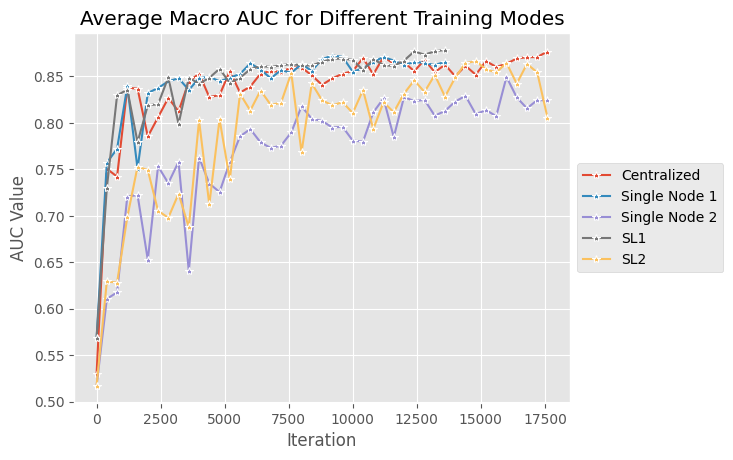

4
Best AUC: 0.8468213867192288
3
Best AUC: 0.8479105070385243
3
Best AUC: 0.8052781169148496
3
Best AUC: 0.8542576820675758
3
Best AUC: 0.8379415115216712


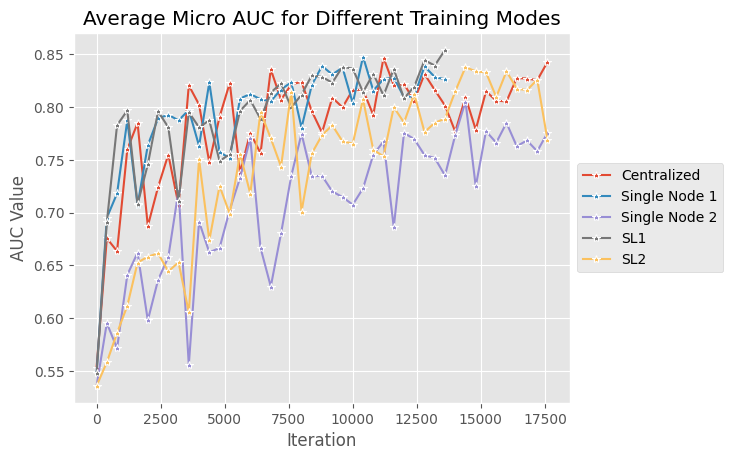

4
Best AUC: 0.8554478609625669
3
Best AUC: 0.8875519904931669
3
Best AUC: 0.8110145573380866
3
Best AUC: 0.8938279857397505
3
Best AUC: 0.8722890671420083


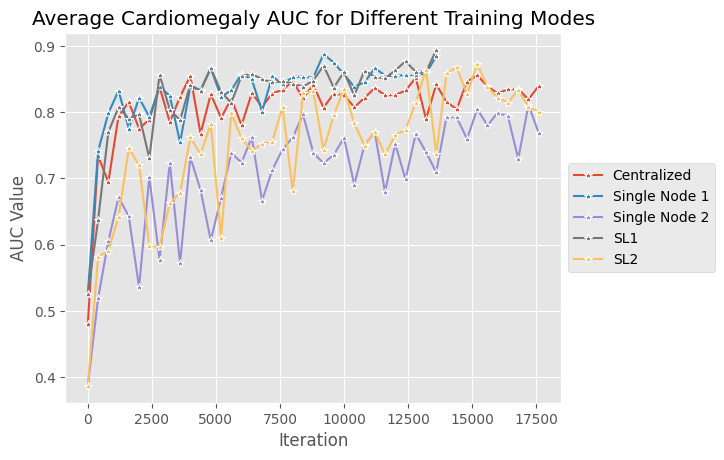

4
Best AUC: 0.9088541666666667
3
Best AUC: 0.8976190476190475
3
Best AUC: 0.8832341269841271
3
Best AUC: 0.9000496031746031
3
Best AUC: 0.9127976190476191


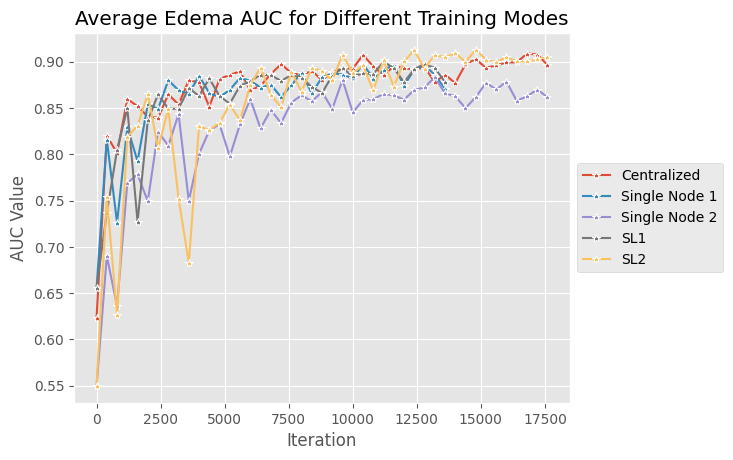

4
Best AUC: 0.9108915441176471
3
Best AUC: 0.8960171568627451
3
Best AUC: 0.887561274509804
3
Best AUC: 0.8982230392156861
3
Best AUC: 0.8965686274509803


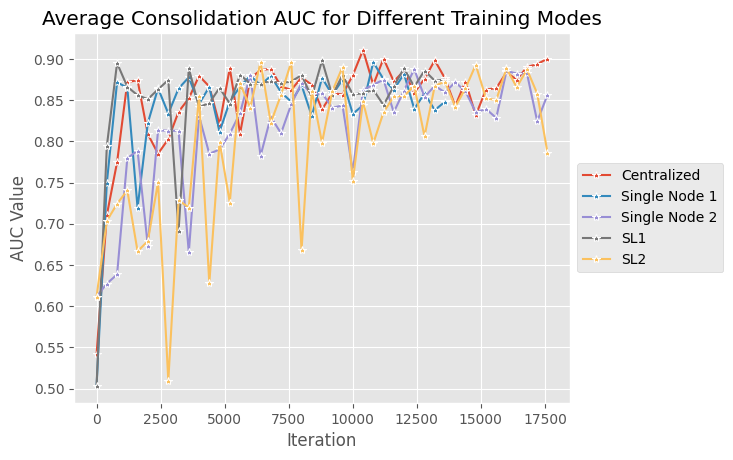

4
Best AUC: 0.8455511811023623
3
Best AUC: 0.8525984251968505
3
Best AUC: 0.8232545931758529
3
Best AUC: 0.8613123359580053
3
Best AUC: 0.8095538057742783


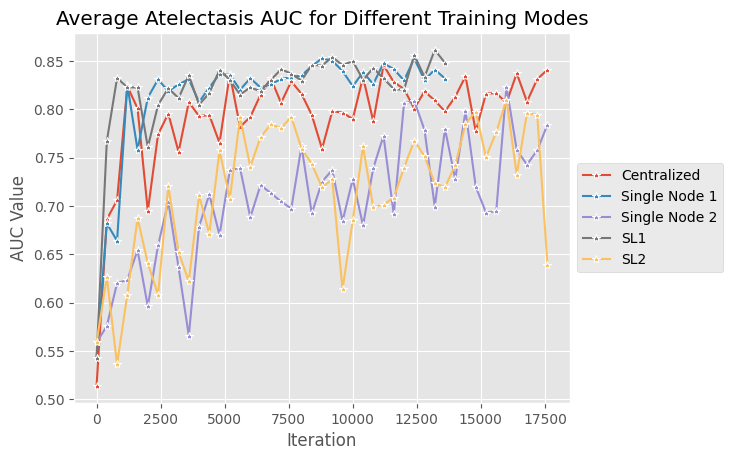

4
Best AUC: 0.9118829257246377
3
Best AUC: 0.8940972222222223
3
Best AUC: 0.8704332729468599
3
Best AUC: 0.8980223429951691
3
Best AUC: 0.9106280193236714


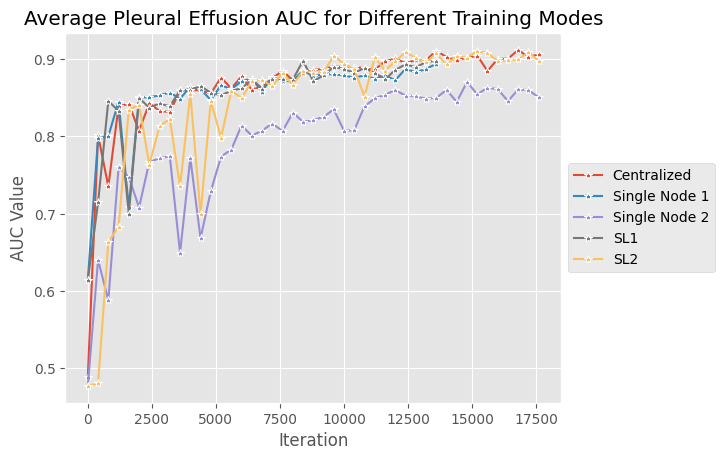

In [57]:
results = {'Centralized': centralized_results, 'Single Node 1': single_node_results, 'Single Node 2': single_node_results_2, 'SL1': sl1_results, 'SL2': sl2_results}
line_plot(results, 'val_auc_mean', 'Average Macro AUC for Different Training Modes')
line_plot(results, 'val_auc_mean_micro', 'Average Micro AUC for Different Training Modes')
line_plot(results, 'Cardiomegaly', 'Average Cardiomegaly AUC for Different Training Modes')
line_plot(results, 'Edema', 'Average Edema AUC for Different Training Modes')
line_plot(results, 'Consolidation', 'Average Consolidation AUC for Different Training Modes')
line_plot(results, 'Atelectasis', 'Average Atelectasis AUC for Different Training Modes')
line_plot(results, 'Pleural Effusion', 'Average Pleural Effusion AUC for Different Training Modes')   

4
Best AUC: 0.8767896677116818
3
Best AUC: 0.8724608699426261
3
Best AUC: 0.8785042647050106


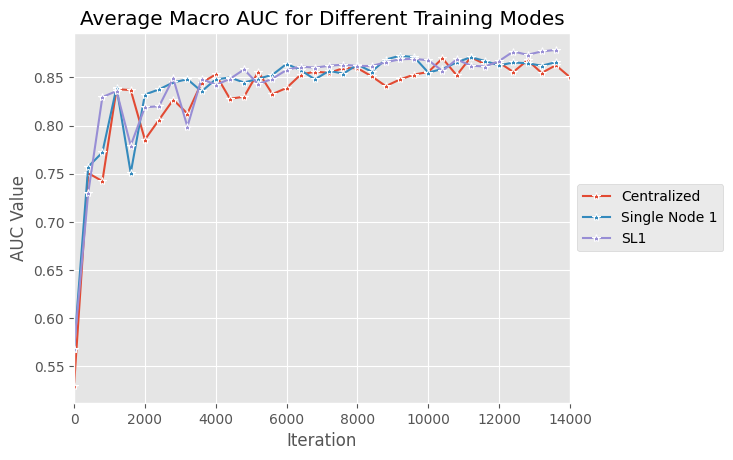

4
Best AUC: 0.8468213867192288
3
Best AUC: 0.8479105070385243
3
Best AUC: 0.8542576820675758


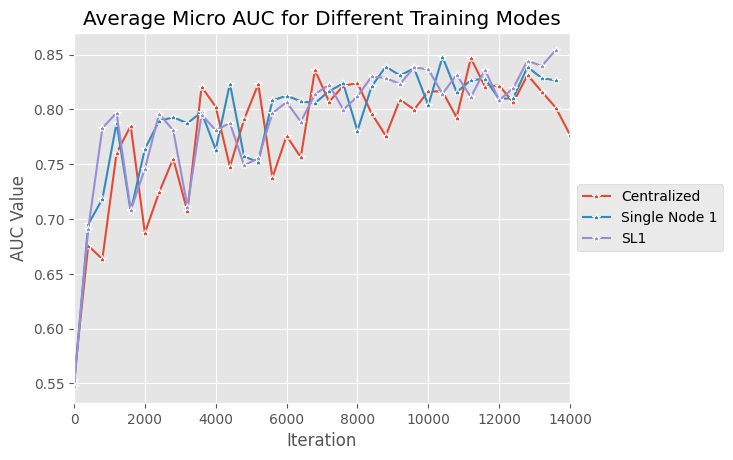

4
Best AUC: 0.8554478609625669
3
Best AUC: 0.8875519904931669
3
Best AUC: 0.8938279857397505


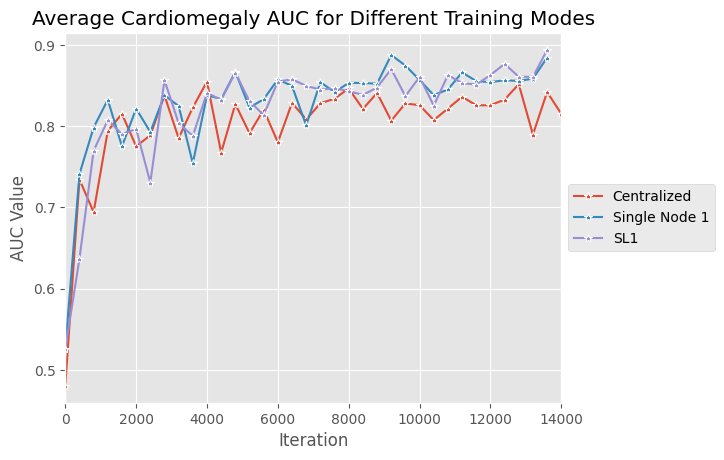

4
Best AUC: 0.9088541666666667
3
Best AUC: 0.8976190476190475
3
Best AUC: 0.9000496031746031


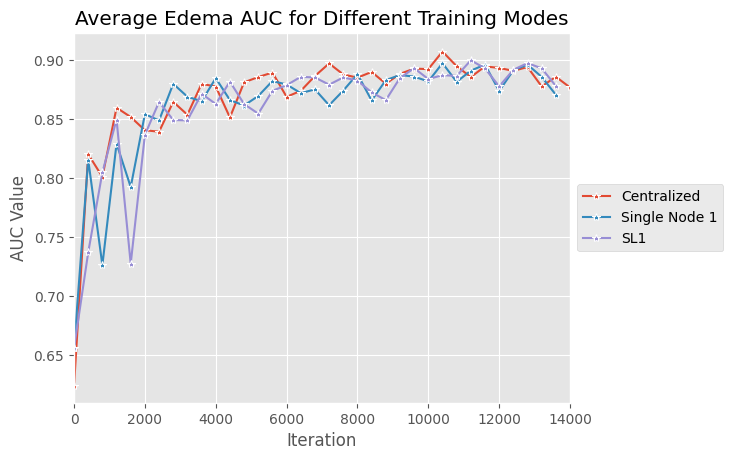

4
Best AUC: 0.9108915441176471
3
Best AUC: 0.8960171568627451
3
Best AUC: 0.8982230392156861


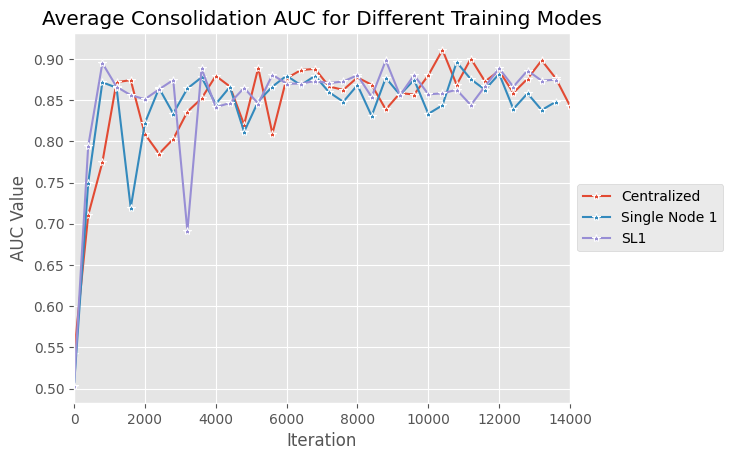

4
Best AUC: 0.8455511811023623
3
Best AUC: 0.8525984251968505
3
Best AUC: 0.8613123359580053


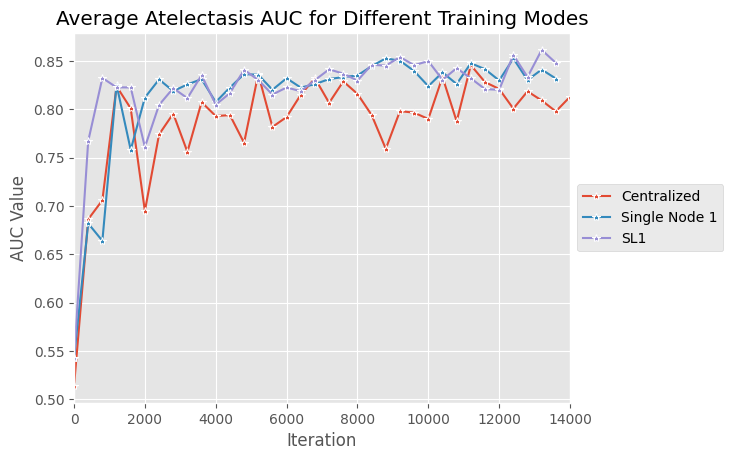

4
Best AUC: 0.9118829257246377
3
Best AUC: 0.8940972222222223
3
Best AUC: 0.8980223429951691


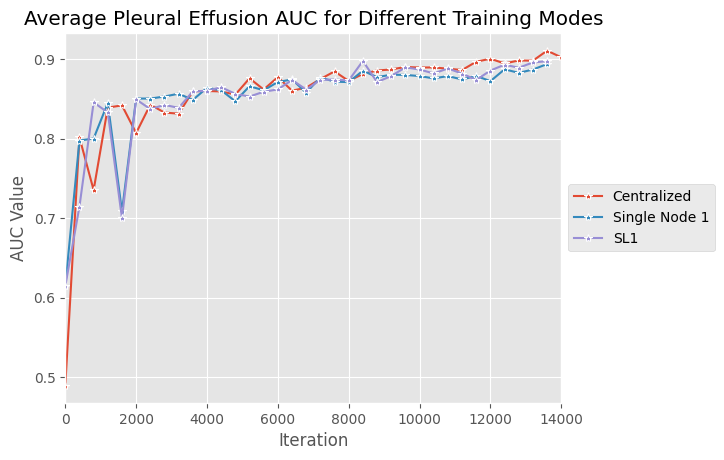

In [55]:
results = {'Centralized': centralized_results, 'Single Node 1': single_node_results, 'SL1': sl1_results}
line_plot(results, 'val_auc_mean', 'Average Macro AUC for Different Training Modes')
line_plot(results, 'val_auc_mean_micro', 'Average Micro AUC for Different Training Modes')
line_plot(results, 'Cardiomegaly', 'Average Cardiomegaly AUC for Different Training Modes')
line_plot(results, 'Edema', 'Average Edema AUC for Different Training Modes')
line_plot(results, 'Consolidation', 'Average Consolidation AUC for Different Training Modes')
line_plot(results, 'Atelectasis', 'Average Atelectasis AUC for Different Training Modes')
line_plot(results, 'Pleural Effusion', 'Average Pleural Effusion AUC for Different Training Modes') 

4
Best AUC: 0.8767896677116818
3
Best AUC: 0.849464866941766
3
Best AUC: 0.8664702582406504


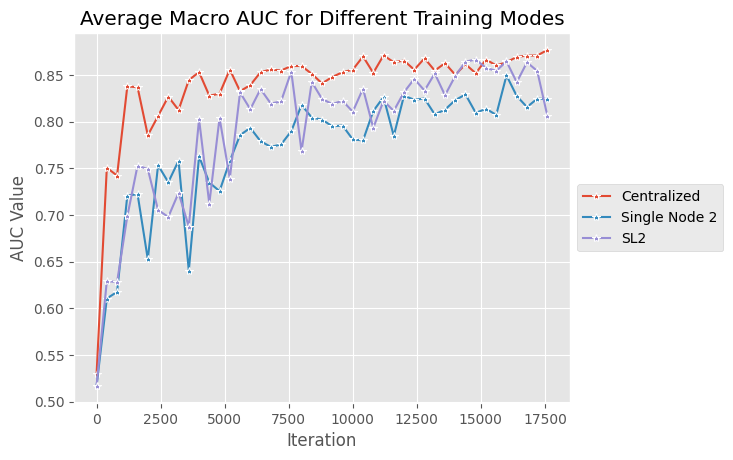

4
Best AUC: 0.8468213867192288
3
Best AUC: 0.8052781169148496
3
Best AUC: 0.8379415115216712


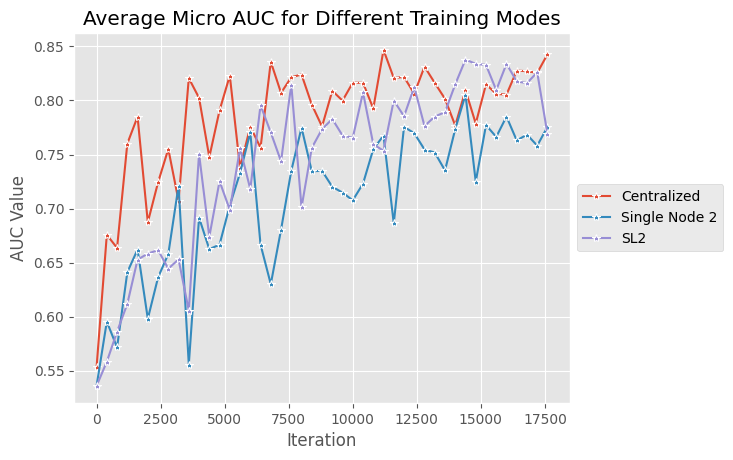

4
Best AUC: 0.8554478609625669
3
Best AUC: 0.8110145573380866
3
Best AUC: 0.8722890671420083


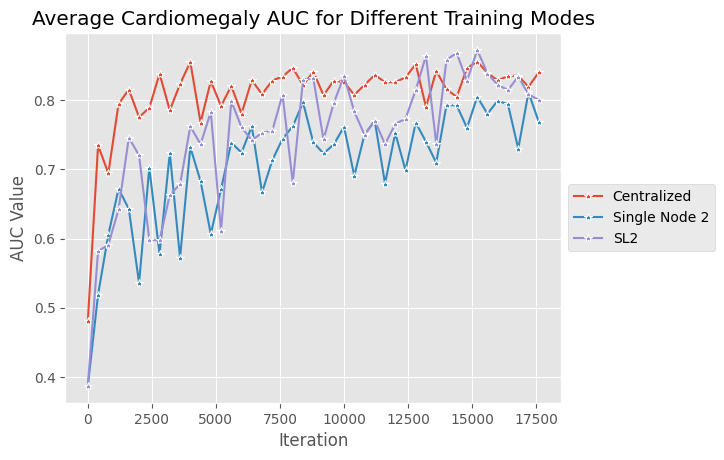

4
Best AUC: 0.9088541666666667
3
Best AUC: 0.8832341269841271
3
Best AUC: 0.9127976190476191


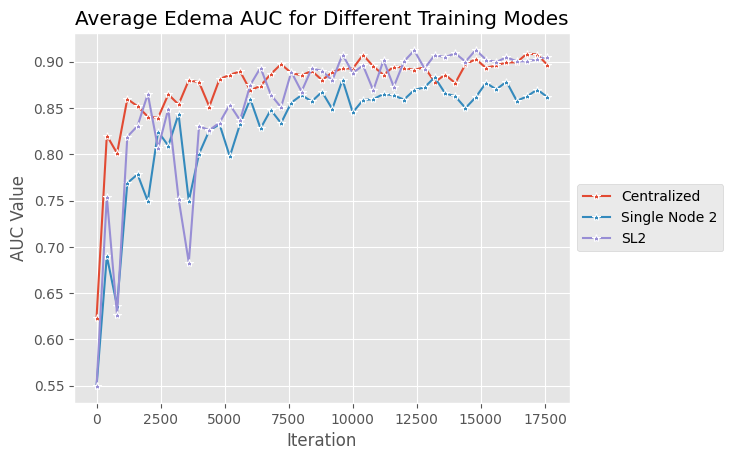

4
Best AUC: 0.9108915441176471
3
Best AUC: 0.887561274509804
3
Best AUC: 0.8965686274509803


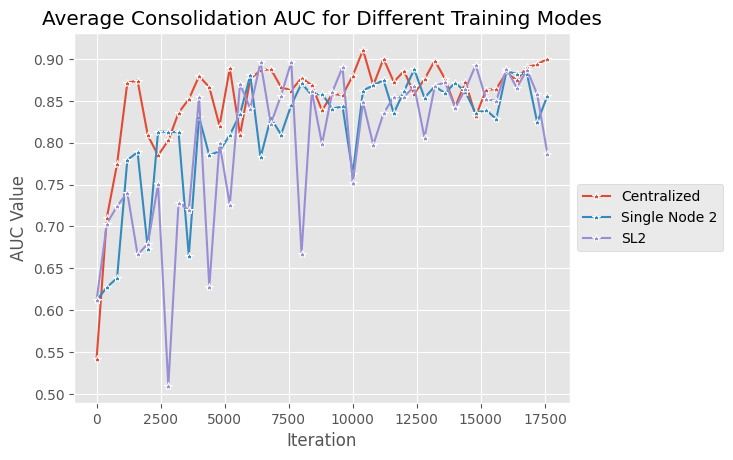

4
Best AUC: 0.8455511811023623
3
Best AUC: 0.8232545931758529
3
Best AUC: 0.8095538057742783


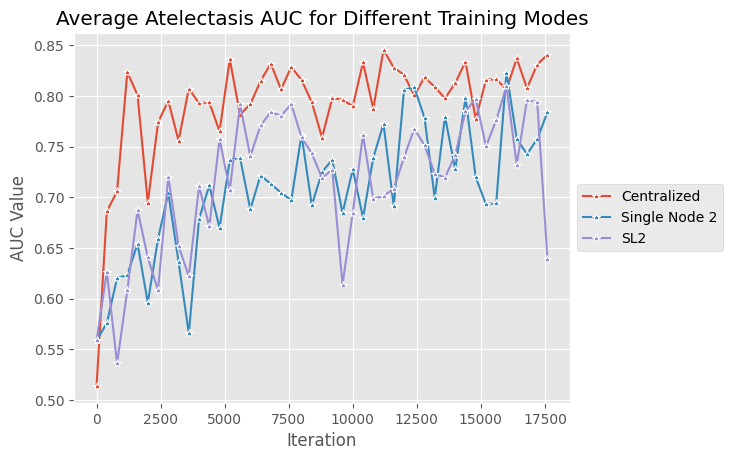

4
Best AUC: 0.9118829257246377
3
Best AUC: 0.8704332729468599
3
Best AUC: 0.9106280193236714


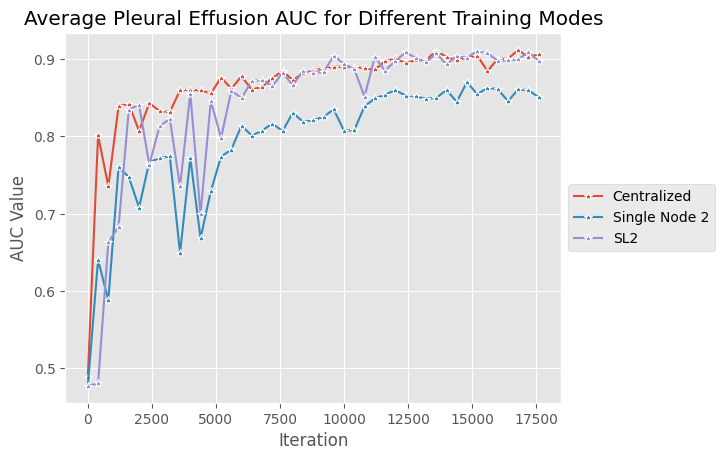

In [43]:
results = {'Centralized': centralized_results, 'Single Node 2': single_node_results_2, 'SL2': sl2_results}
line_plot(results, 'val_auc_mean', 'Average Macro AUC for Different Training Modes')
line_plot(results, 'val_auc_mean_micro', 'Average Micro AUC for Different Training Modes')
line_plot(results, 'Cardiomegaly', 'Average Cardiomegaly AUC for Different Training Modes')
line_plot(results, 'Edema', 'Average Edema AUC for Different Training Modes')
line_plot(results, 'Consolidation', 'Average Consolidation AUC for Different Training Modes')
line_plot(results, 'Atelectasis', 'Average Atelectasis AUC for Different Training Modes')
line_plot(results, 'Pleural Effusion', 'Average Pleural Effusion AUC for Different Training Modes')   

# Inspect AUC and Precision-Recall Curves for each class

In [17]:
dataDir = 'host_data/train_data/LungDiseaseDataset'
data_root = os.path.join(dataDir, 'CheXpert-v1.0-small')
batch_size = 32
train_cols = all_classes
train_cols = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',  'Pleural Effusion']

5

In [29]:
testSet     =  CheXpert(csv_path=os.path.join(data_root, 'valid.csv'),  image_root_path=data_root, use_upsampling=False, use_frontal=True, image_size=320, mode='valid', class_index=-1)
testloader  =  torch.utils.data.DataLoader(testSet, batch_size=batch_size, num_workers=2, drop_last=False, shuffle=False)

# train_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
# batch_size=32
# dataDir = 'host_data/train_data/LungDiseaseDataset'
# data_root = os.path.join(dataDir, 'CheXpert-v1.0-small')
# testSet     =  CheXpert(csv_path=os.path.join(data_root, 'valid.csv'),  image_root_path=data_root, use_upsampling=False, use_frontal=True, image_size=320, mode='valid', class_index=-1, verbose=False, train_cols=train_cols)
# testloader  =  torch.utils.data.DataLoader(testSet, batch_size=batch_size, num_workers=2, drop_last=False, shuffle=False)
# for x, y in testloader:
#     break

model_state = torch.load('./host_data/output/checkpoint_host1/sl3/checkpoint_best.pth.tar')
#model_state = torch.load('./host_data/output/checkpoint_host1/sl2/checkpoint_best.pth.tar')
#model_state = torch.load('./host_data/output/checkpoint_host1/centralized2/checkpoint_best.pth.tar')
model_wrapper = Custom_Densenet121(number_classes=len(train_cols), pretrained=False, online_pretrained_weight_store_path=None)
model_wrapper.model.load_state_dict(model_state['model_state_dict'])
model_wrapper.model.cuda()

/tmp/test/workspace_lung_disease/sl_version/model/src/dataloader_robust.py:41: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df['Path'] = self.df['Path'].str.replace('CheXpert-v1.0-small/', '')
/tmp/test/workspace_lung_disease/sl_version/model/src/dataloader_robust.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df['Path'] = self.df['Path'].str.replace('CheXpert-v1.0/', '')


Multi-label mode: True, Number of classes: [5]
------------------------------
Found 202 images in total, 66 positive images, 136 negative images
Cardiomegaly(C0): imbalance ratio is 0.3267

Found 202 images in total, 42 positive images, 160 negative images
Edema(C1): imbalance ratio is 0.2079

Found 202 images in total, 32 positive images, 170 negative images
Consolidation(C2): imbalance ratio is 0.1584

Found 202 images in total, 75 positive images, 127 negative images
Atelectasis(C3): imbalance ratio is 0.3713

Found 202 images in total, 64 positive images, 138 negative images
Pleural Effusion(C4): imbalance ratio is 0.3168

------------------------------


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (elu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (elu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (elu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (elu

In [30]:
model_wrapper.model.eval()
with torch.no_grad():    
    test_pred = []
    test_true = [] 
    for jdx, data in enumerate(testloader):
        test_data, test_labels = data
        test_data = test_data.cuda()
        y_pred = model_wrapper.model(test_data)
        y_pred = torch.sigmoid(y_pred)
        test_pred.append(y_pred.cpu().detach().numpy())
        test_true.append(test_labels.numpy())
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    mask = test_true.sum(axis=0)<25
    test_true = test_true[:, ~mask]
    test_pred = test_pred[:,~mask]
    val_auc_mean =  roc_auc_score(test_true, test_pred, average="macro") 
    val_auc_mean_micro =  roc_auc_score(test_true, test_pred, average="micro") 
    val_auc_class =  roc_auc_score(test_true, test_pred, average=None) 
list(np.array(testSet.select_cols)[~mask])

['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']

In [55]:
average_precision_score(test_true[:,0].astype('int8'), test_pred[:,0])


0.808625329621903

Recall   : Higher is better because it indicates higher rate of detecting the patient.
False Positive Rate: Lower is better because it indicates lower chance of misclassiying the normal person as patient.
Precision: Higher is better because it indicates higher proportion of positive predictions are valid patients.
0.8932300686170331 0.8746990669235936
['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']
[0.9063057  0.8985119  0.90625    0.86740157 0.88768116]


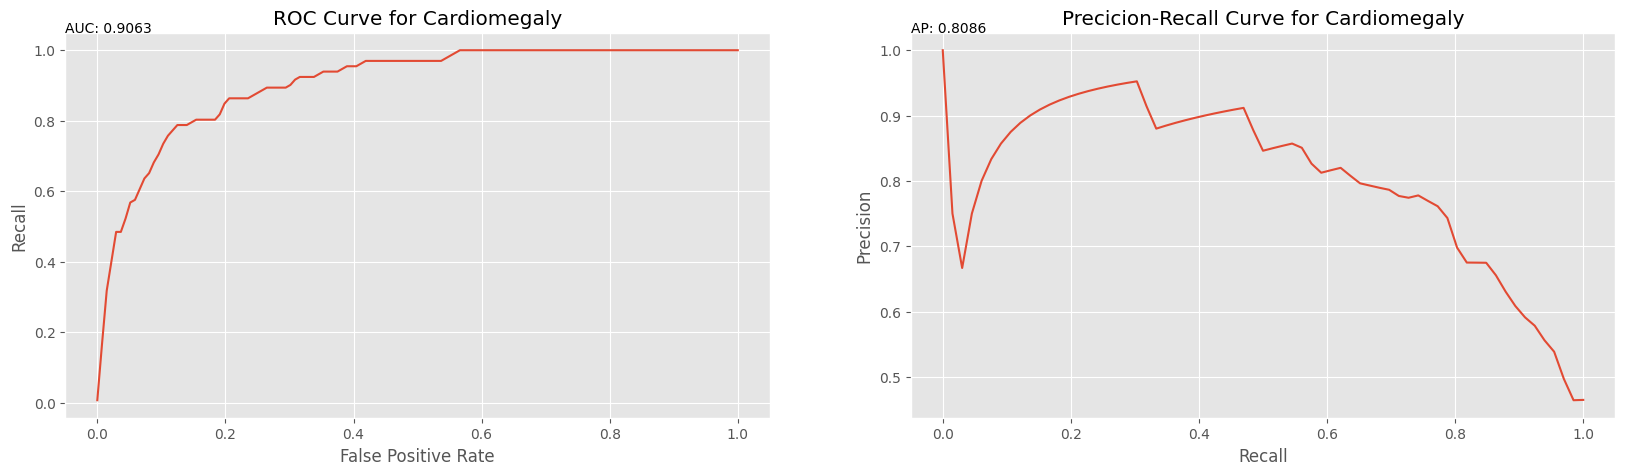

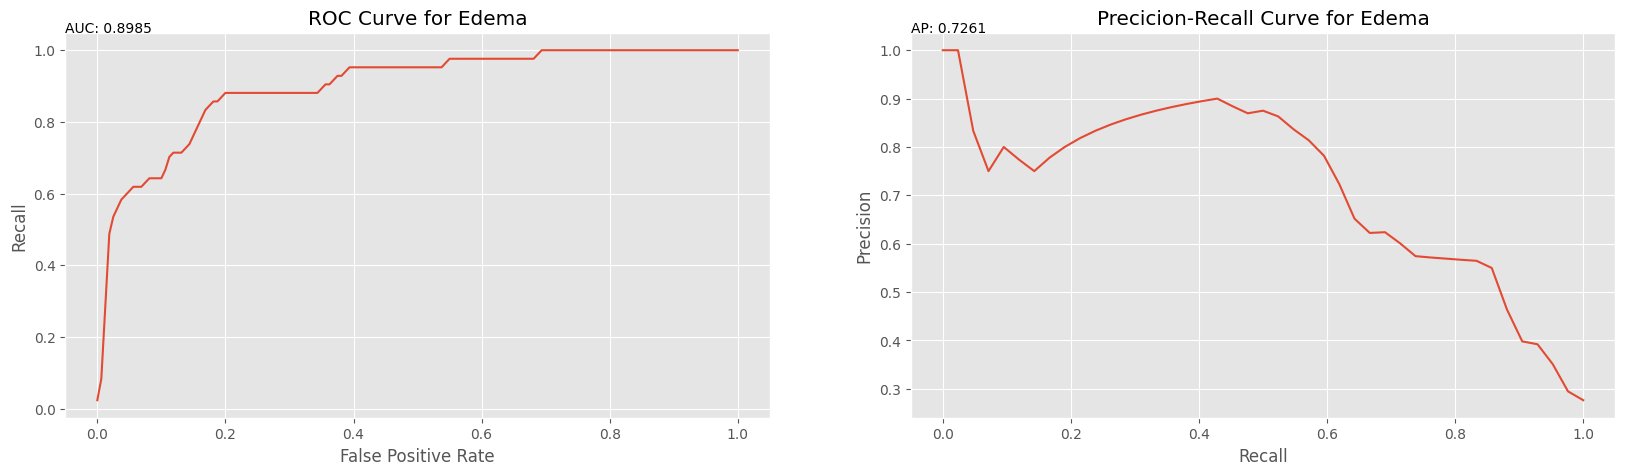

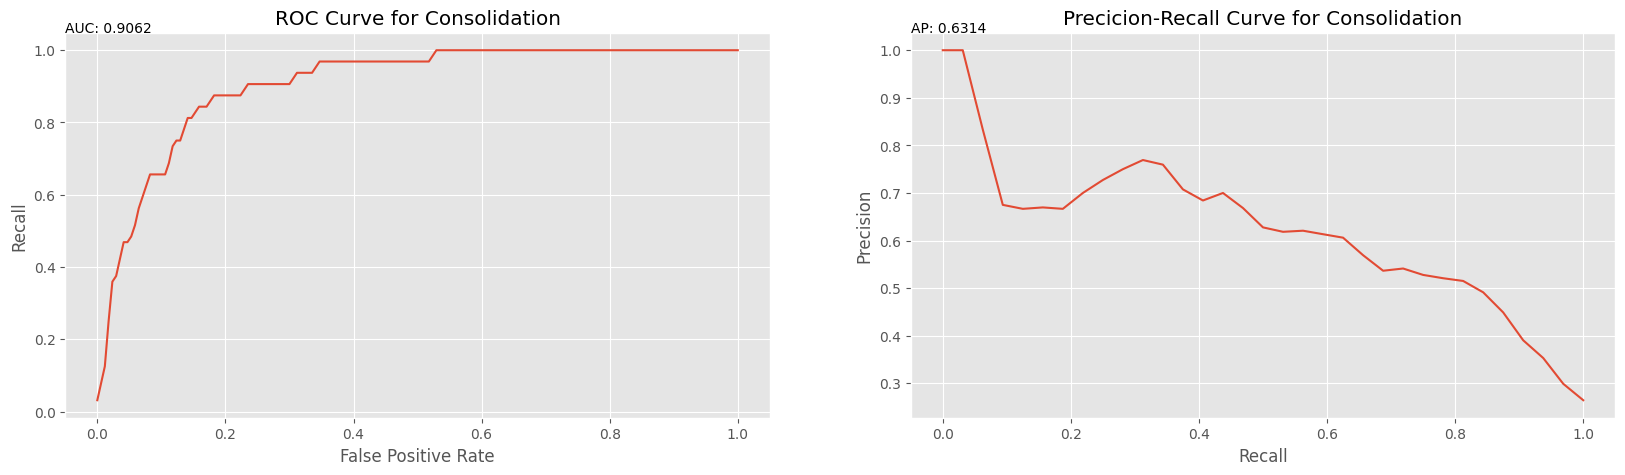

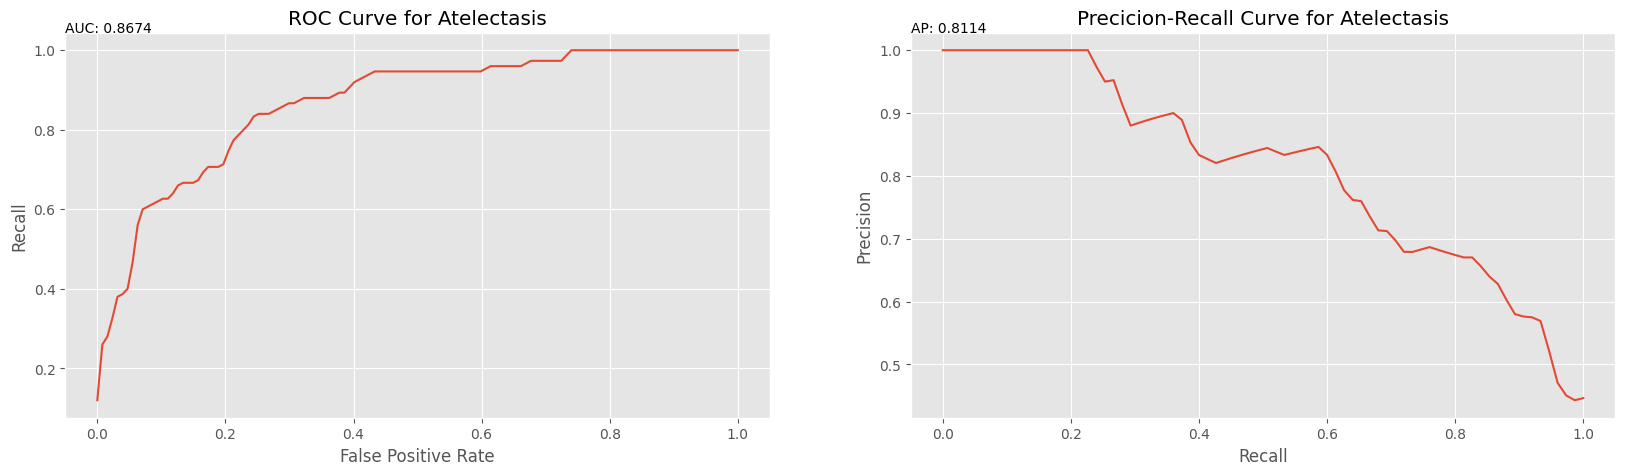

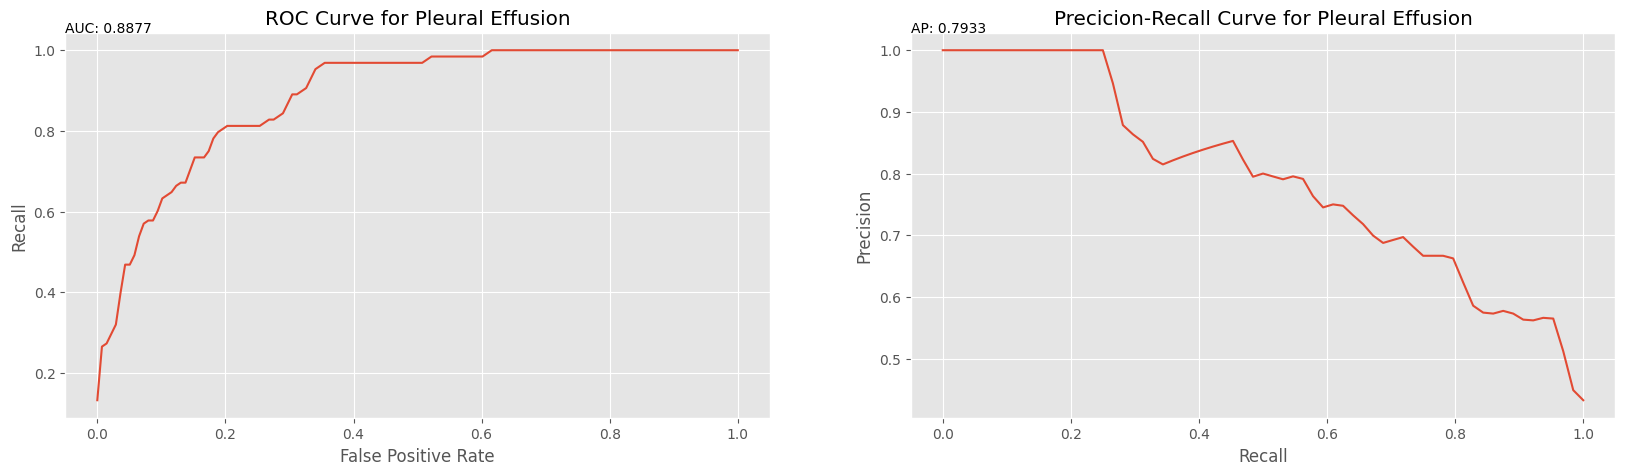

In [57]:
def visualize_model_curve(y, y_scores, pos_label=1, drop_intermediate=False, train_cols=None):

    for i in range(y.shape[1]):
        true_y=y[:,i]
        pred_y_score=y_scores[:,i]
        fig, axes = plt.subplots(1,2, figsize=(20,5))
        fpr1, sen1, th1 = roc_curve(true_y, pred_y_score, pos_label=1, drop_intermediate=False)
        pre2, sen2, th2 = precision_recall_curve(true_y, pred_y_score, pos_label=1)
        sns.lineplot(pd.DataFrame({'False Positive Rate':fpr1, 'Recall': sen1}), x='False Positive Rate', y='Recall', ax=axes[0], errorbar=None)
        axes[0].axes.set_title('ROC Curve for {}'.format(train_cols[i]))
        axes[0].annotate('AUC: {:.4f}'.format(roc_auc_score(true_y, pred_y_score, pos_label=1)),xy=(0,1.0), xycoords='axes fraction')
        sns.lineplot(pd.DataFrame({'Precision':pre2, 'Recall': sen2}), x='Recall', y='Precision', ax=axes[1], errorbar=None)
        axes[1].axes.set_title('Precicion-Recall Curve for {}'.format(train_cols[i]))
        ap = average_precision_score(true_y, pred_y_score, pos_label=1)
        axes[1].annotate('AP: {:.4f}'.format(ap),xy=(0,1.0), xycoords='axes fraction')
        plt.show()

print("Recall   : Higher is better because it indicates higher rate of detecting the patient.")
print("False Positive Rate: Lower is better because it indicates lower chance of misclassiying the normal person as patient.")
print("Precision: Higher is better because it indicates higher proportion of positive predictions are valid patients.")
print(val_auc_mean, val_auc_mean_micro)
print(train_cols)
print(val_auc_class)
visualize_model_curve(test_true, test_pred, train_cols=train_cols)

In [68]:
#fpr, sen, th1 = roc_curve(test_true, test_pred, pos_label=1, drop_intermediate=False)
for i in range(test_true.shape[1]):
    print(i)

0
1
2
3
4
